This notebook attempts to back out neural scaling laws from datamodel coefficients.

It is based on the theory [here](https://ttw-public.notion.site/Datamodels-Per-datapoint-cliff-learning-491c8467f85e4d61be0026c1adb8b1d7).

### Load libraries

In [1]:
import pathlib

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)

### Load paper data

In [2]:
df_bahri = pd.read_csv(GIT_ROOT / "data/bahri-2021/cifar10/wpd-clean.csv")
df_bahri["loss"] = df_bahri.xent

df_rosenfeld = pd.read_csv(
    GIT_ROOT / "data/rosenfeld-cifar10/wpd-clean.csv"
)

### Read datamodels data

In [3]:
pcts = [10, 20, 50, 75]
dms = []

for pct in tqdm(pcts):
    dm = torch.load(
        f"/projects/scaling/datamodels/cifar10/test_{pct}pct.pt",
        map_location=torch.device("cpu"),
    )
    dms.append(dm)

dms[0]["weight"].shape, dms[0]["bias"].shape, dms[0].keys()

  0%|          | 0/4 [00:00<?, ?it/s]

(torch.Size([50000, 10000]),
 torch.Size([10000]),
 dict_keys(['lam', 'weight', 'bias', 'train_loss']))

What is `train_loss`? Note that it goes up with pct.

In [4]:
[dm["train_loss"].mean().item() for dm in dms]

[0.4719109833240509,
 0.7317387461662292,
 1.3007742166519165,
 1.3337242603302002]

# Preliminary datamodels analysis

### Distribution of $\kappa_2^{\mu_\mathsf{x}}$

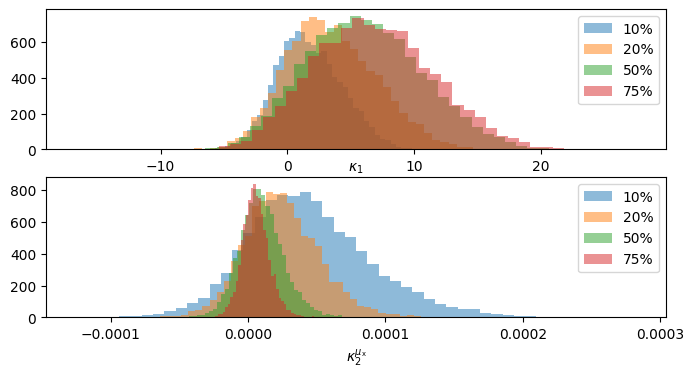

In [5]:
plt.figure(figsize=(8, 4))

plt.subplot(2, 1, 1)
for pct, dm in zip(pcts, dms):
    plt.hist(dm["bias"], bins=50, label=f"{pct}%", alpha=0.5)
plt.xlabel(r"$\kappa_1$")
# Move xlabel up
plt.gca().xaxis.set_label_coords(0.5, -0.08)
plt.legend()

plt.subplot(2, 1, 2)
for pct, dm in zip(pcts, dms):
    plt.hist(dm["weight"].mean(axis=0), bins=50, label=f"{pct}%", alpha=0.5)
plt.xlabel(r"$\kappa_2^{\mu_{\mathsf{x}}}$")
plt.legend()

plt.show()

In [6]:
[(dm["weight"].mean(axis=0) < 0).float().mean() for dm in dms]

[tensor(0.1510), tensor(0.1761), tensor(0.2641), tensor(0.2726)]

The fact that 15% to 27% of test data points have a negative datamodels
$\kappa_2$ indiciates that datamodels are not useful for extrapolating
data-scaling laws.

### Attempt to normalize distributions

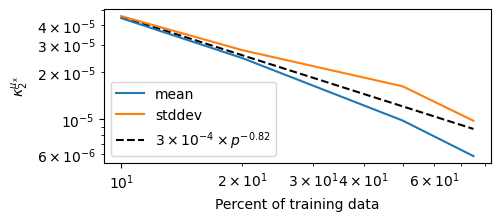

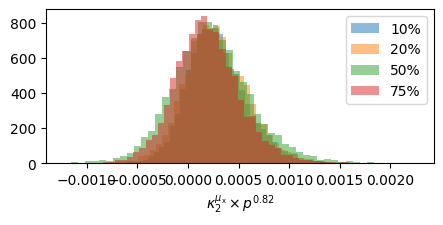

In [7]:
means = [dm["weight"].mean(axis=0).mean() for dm in dms]
stddevs = [dm["weight"].mean(axis=0).std() for dm in dms]

plt.figure(figsize=(5, 2))
plt.plot(pcts, means, label="mean")
plt.plot(pcts, stddevs, label="stddev")
plt.plot(
    pcts,
    np.array(pcts) ** -0.82 * 3e-4,
    label=r"$3 \times 10^{-4} \times p^{-0.82}$",
    linestyle="--",
    color="black",
    zorder=-1
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Percent of training data")
plt.ylabel(r"$\kappa_2^{\mu_{\mathsf{x}}}$")
plt.legend()
plt.show()

plt.figure(figsize=(5, 2))
for pct, dm in zip(pcts, dms):
    plt.hist(dm["weight"].mean(axis=0) * pct ** 0.81, bins=50, label=f"{pct}%", alpha=0.5)
plt.xlabel(r"$\kappa_2^{\mu_{\mathsf{x}}} \times p^{0.82}$")
plt.legend()
plt.show()

### Consistency of $\kappa_2^{\mu_\mathsf{x}}$ across pcts

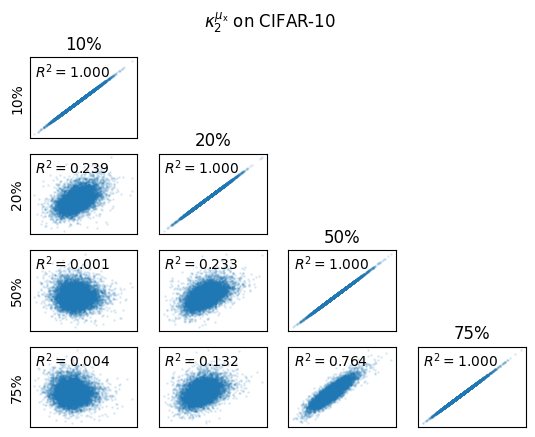

In [8]:
# Make a pcts by pcts grid of plots
# Each plot should be a scatter plot of kappa_2^mu for pcts[i] vs pcts[j]
# Don't plot anything below the diagonal
plt.suptitle(r"$\kappa_2^{\mu_{\mathsf{x}}}$ on CIFAR-10")
for i in range(len(pcts)):
    for j in range(len(pcts)):
        plt.subplot(len(pcts), len(pcts), i * len(pcts) + j + 1)
        if i < j:
            plt.axis("off")
            continue
        plt.scatter(
            dms[i]["weight"].mean(axis=0),
            dms[j]["weight"].mean(axis=0),
            s=1,
            alpha=0.1,
        )
        # Show the R^2 value
        r2 = np.corrcoef(
            dms[i]["weight"].mean(axis=0),
            dms[j]["weight"].mean(axis=0),
        )[0, 1] ** 2
        plt.text(
            0.05,
            0.95,
            f"$R^2 = {r2:.3f}$",
            transform=plt.gca().transAxes,
            verticalalignment="top",
        )
        plt.xticks([])
        plt.yticks([])
        if i == j:
            plt.title(f"{pcts[j]}%")
        if j == 0:
            plt.ylabel(f"{pcts[i]}%")

### $\kappa_1$ vs $\kappa_2^{\mu_\mathsf{x}}$

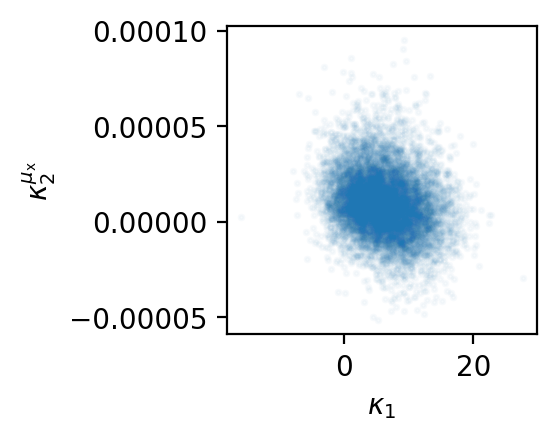

In [9]:
dm = dms[2]
plt.figure(figsize=(2, 2), dpi=200)
plt.scatter(dm["bias"], dm["weight"].mean(axis=0), s=3, alpha=0.03)
plt.xlabel(r"$\kappa_1$")
plt.ylabel(r"$\kappa_2^{\mu_\mathsf{x}}$")
plt.show()

### Compute scaling law from datamodel

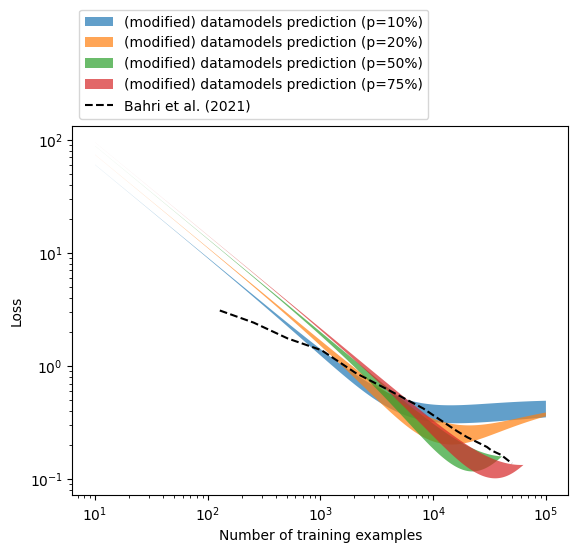

In [10]:
def softplus_np(x):
    """https://stackoverflow.com/a/51828104"""
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

alpha = 0.82
for dm, p in zip(dms, pcts):
    k1s = dm["bias"].numpy()
    k2s = dm["weight"].mean(axis=0).numpy()
    # k2s = np.maximum(dm["weight"].mean(axis=0).numpy(), 0)

    n_trains = np.logspace(start=1, stop=5, num=1000)

    rescale_factor = (p / 100 * 5e4 / n_trains.reshape(-1, 1)) ** alpha
    raw_margin_lo = rescale_factor * (
        -k1s.reshape(1, -1) - 9 * k2s.reshape(1, -1) * n_trains.reshape(-1, 1)
    )
    raw_margin_hi = rescale_factor * (
        -k1s.reshape(1, -1) - k2s.reshape(1, -1) * n_trains.reshape(-1, 1)
    )

    loss_lo = softplus_np(raw_margin_lo).mean(axis=-1)
    loss_hi = softplus_np(raw_margin_hi).mean(axis=-1)

    plt.fill_between(
        n_trains, loss_lo, np.maximum(loss_hi, loss_lo), alpha=0.7,
        label=f"(modified) datamodels prediction ({p=}%)"
    )

plt.plot(
    df_bahri.n_train,
    df_bahri.loss,
    label="Bahri et al. (2021)",
    zorder=10,
    color="black",
    linestyle="--",
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training examples")
plt.ylabel("Loss")
# Legend on outside top left
plt.legend(bbox_to_anchor=(0, 1), loc="lower left")

plt.show()